In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
import scipy.spatial as spt
from sklearn.cross_validation import train_test_split

import edward as ed
from edward.models import Normal, Dirichlet, Multinomial, Gamma, Empirical
from tensorflow.contrib.linalg import LinearOperatorTriL
import itertools
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')
import bijectors as bijector

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ImportError: cannot import name NOT_REPARAMETERIZED. Your TensorFlow version is not supported.

In [2]:
tf.__version__

'1.0.0'

Express a matrix of real-valued variables as a product of a binary matrix and a real-valued matrix:

\begin{align}
\mathbf{X} = \mathbf{M}\mathbf{G} + \mathbf{E}
\end{align}

where 
\begin{align}
\mathbf{X} \textrm{ is an } n\times d \textrm{ matrix of real-valued observations } \\
\mathbf{M} \textrm{ is an } n\times k \textrm{ matrix of cluster assignments, s.t. }\\ \pi_j \sim Dirichlet(\alpha),\\ \mathbf{M}_i \sim \mathrm{Multinomial}(\pi) \\
\mathbf{G} \textrm{ is a } k\times d \textrm{ matrix of cluster means, s.t. }\\ \pi_j \sim Dirichlet(\alpha),\\
\end{align}

tmp = Gamma(1.,1.)
tmp2 = Gamma(.5,.5)
x = np.arange(0,10.,0.01,dtype=np.float32)
px = tmp.prob(x).eval()
px2 = tmp2.prob(x).eval()
plt.plot(x,px,color='r')
plt.plot(x,px2,color='g')

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,15

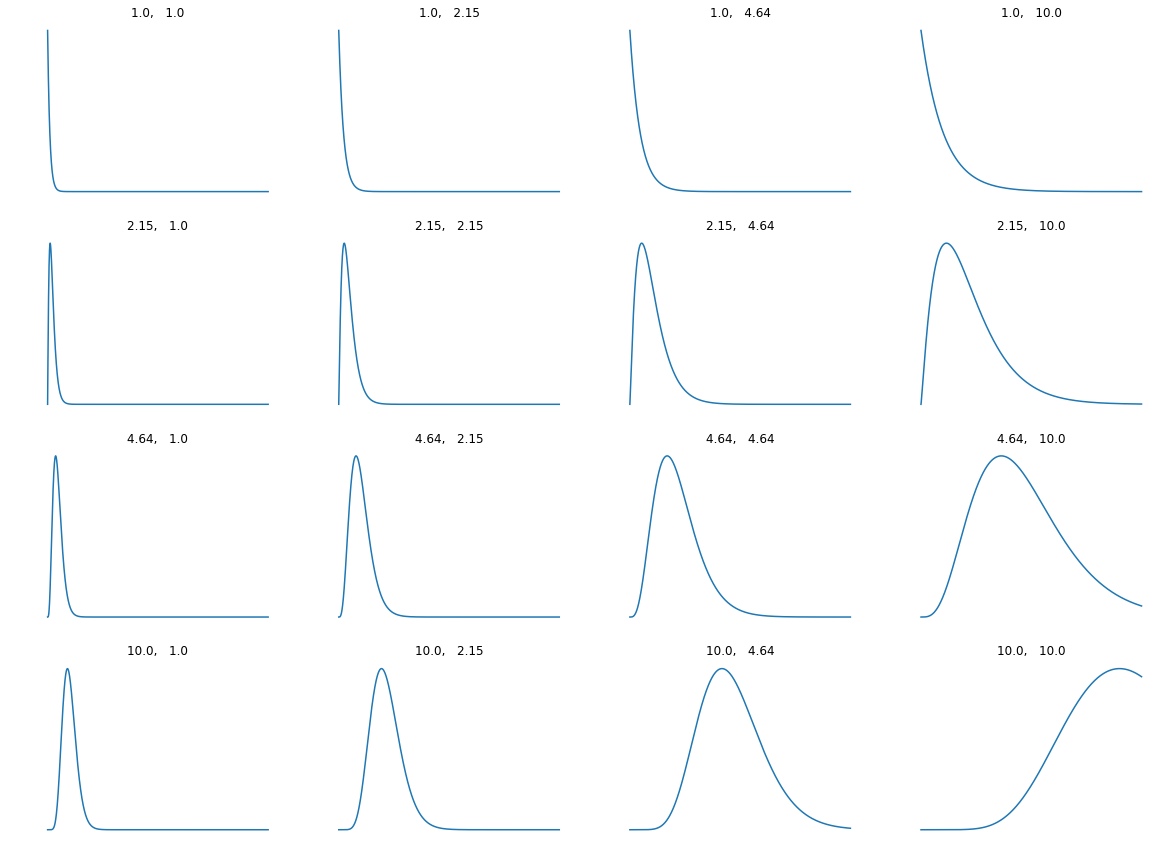

In [3]:
x = np.arange(0,100,0.01)
c = 1
for a in np.logspace(0,1,4):
    for b in np.logspace(0,1,4):
        plt.subplot(4,4,c)
        plt.title(str(np.round(a,2))+",   "+str(np.round(b,2)))
        plt.plot(x,sps.gamma.pdf(x=x,a=a,scale=b))
        plt.axis('off')
        c += 1

In [4]:
# from Gross et al. page 3
N = 500
K = 2
D = 2

In [5]:
N,K,D

(500, 2, 2)

In [6]:
mean_precision_shape,mean_precision_rate,obs_precision_shape,obs_precision_rate = 4.,200.,6.,10.

# p model
alpha = 1
pi = Dirichlet(np.atleast_1d(alpha*np.ones(K)).astype(np.float32))
z = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(pi,[N]),[N,K]))
sigma2_mu_k = ed.models.InverseGamma([mean_precision_shape],[mean_precision_rate])
sigma2_mu_d = ed.models.InverseGamma(mean_precision_shape*tf.ones([D]),mean_precision_rate*tf.ones([D]))
sigma2_mu = tf.reshape(tf.tile(sigma2_mu_k, [K]), [K,1])*sigma2_mu_d
mu = ed.models.MultivariateNormalDiag(tf.zeros([K,D]), tf.sqrt(sigma2_mu))
sigma2_obs_n = ed.models.InverseGamma([obs_precision_shape],[obs_precision_rate])
sigma2_obs_d = ed.models.InverseGamma(obs_precision_shape*tf.ones([D]),obs_precision_rate*tf.ones([D]))
sigma2_obs = tf.reshape(tf.tile(sigma2_obs_n, [N]), [N,1])*sigma2_obs_d
x = ed.models.MultivariateNormalDiag(tf.matmul(z, mu), tf.sqrt(sigma2_obs))

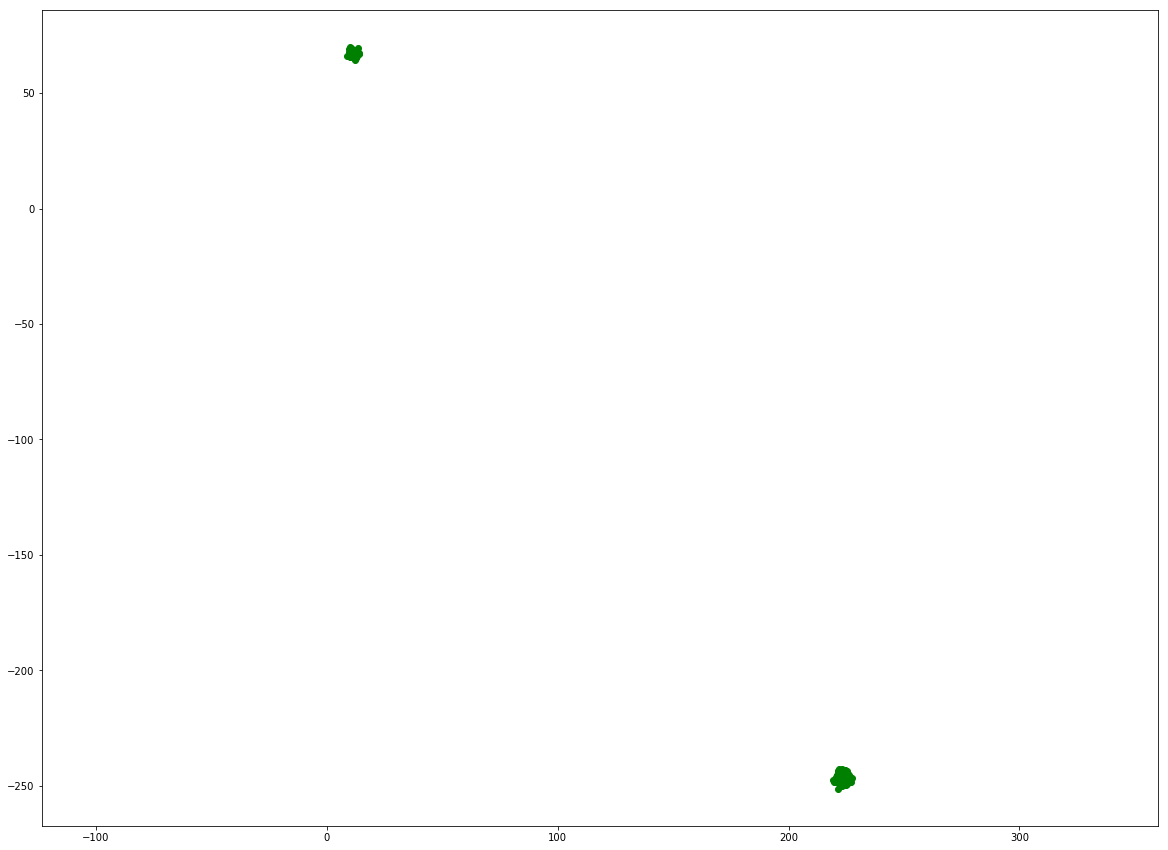

In [8]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    X_sample = x.sample().eval()
    plt.scatter(*X_sample.T,color='g')
    plt.axis('equal');

In [9]:
# q model
#alpha_hat = 1 + tf.nn.softplus(tf.Variable(tf.random_normal([K])))
#qpi = Dirichlet(alpha_hat)
qpi = tf.nn.softmax(tf.Variable(tf.random_normal([N,K])))
#qz = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(qpi,[N]),[N,K]))
qz = Multinomial(total_count=1.,probs=qpi)

mean_precision_shape_hat = tf.Variable(tf.random_normal([1]))
mean_precision_rate_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
qsigma2_mu_k = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(mean_precision_shape_hat,mean_precision_rate_hat),
    bijector=bijector.Exp(),
    name="qsigma2_mu_k")
qsigma2_mu_d = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(mean_precision_shape_hat*tf.ones([D]),mean_precision_rate_hat*tf.ones([D])),
    bijector=bijector.Exp(),
    name="qsigma2_mu_d")
qsigma2_mu = tf.reshape(tf.tile(qsigma2_mu_k, [K]), [K,1])*qsigma2_mu_d

qmu_mean = tf.Variable(tf.zeros([K,D]))
qmu = ed.models.MultivariateNormalDiag(qmu_mean, tf.sqrt(qsigma2_mu))

obs_precision_shape_hat = tf.Variable(tf.random_normal([1]))
obs_precision_rate_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
qsigma2_obs_n = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(obs_precision_shape_hat,obs_precision_rate_hat),
    bijector=bijector.Exp(),
    name="qsigma2_obs_n")
qsigma2_obs_d = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(obs_precision_shape_hat*tf.ones([D]),obs_precision_rate_hat*tf.ones([D])),
    bijector=bijector.Exp(),
    name="qsigma2_obs_d")
qsigma2_obs = tf.reshape(tf.tile(qsigma2_obs_n, [N]), [N,1])*qsigma2_obs_d

In [10]:
variables = [qpi, mean_precision_rate_hat, mean_precision_shape_hat, qmu_mean, obs_precision_rate_hat, obs_precision_shape_hat]

In [11]:
z, qz, mu, qmu, sigma2_mu_k,qsigma2_mu_k, sigma2_mu_d,qsigma2_mu_d, sigma2_obs_n,qsigma2_obs_n, sigma2_obs_d,qsigma2_obs_d

(<ed.RandomVariable 'Multinomial/' shape=(500, 2) dtype=float32>,
 <ed.RandomVariable 'Multinomial_1/' shape=(500, 2) dtype=float32>,
 <ed.RandomVariable 'MultivariateNormalDiag/' shape=(2, 2) dtype=float32>,
 <ed.RandomVariable 'MultivariateNormalDiag_2/' shape=(2, 2) dtype=float32>,
 <ed.RandomVariable 'InverseGamma/' shape=(1,) dtype=float32>,
 <ed.RandomVariable 'qsigma2_mu_k/' shape=(1,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_1/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'qsigma2_mu_d/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_2/' shape=(1,) dtype=float32>,
 <ed.RandomVariable 'qsigma2_obs_n/' shape=(1,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_3/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'qsigma2_obs_d/' shape=(2,) dtype=float32>)

In [12]:
inference = ed.KLqp({z: qz, mu: qmu, sigma2_mu_k:qsigma2_mu_k, sigma2_mu_d:qsigma2_mu_d, sigma2_obs_n:qsigma2_obs_n, sigma2_obs_d:qsigma2_obs_d}, data={x: X_sample})
inference.initialize(n_iter=10000, n_print=10, n_samples=130)#, optimizer='rmsprop')

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [13]:
variables

[<tf.Tensor 'Softmax:0' shape=(500, 2) dtype=float32>,
 <tf.Tensor 'Softplus:0' shape=(1,) dtype=float32>,
 <tf.Variable 'Variable_1:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(2, 2) dtype=float32_ref>,
 <tf.Tensor 'Softplus_1:0' shape=(1,) dtype=float32>,
 <tf.Variable 'Variable_4:0' shape=(1,) dtype=float32_ref>]

In [14]:
learning_curve = []
variables_evolutions = [[] for var in variables]
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
    [variables_evolution.append(variable.eval()) for (variable, variables_evolution) in zip(variables,variables_evolutions)]

{'t': 1, 'loss': 18739864.0}
{'t': 1001, 'loss': 251258.06}
{'t': 2001, 'loss': 177502.92}
{'t': 3001, 'loss': 182803.06}
{'t': 4001, 'loss': 206535.88}
{'t': 5001, 'loss': 155722.56}
{'t': 6001, 'loss': 34511.262}
{'t': 7001, 'loss': 208736.78}
{'t': 8001, 'loss': 131447.14}
{'t': 9001, 'loss': 116465.27}


In [15]:
variables_evolutions[3][0].ndim

2

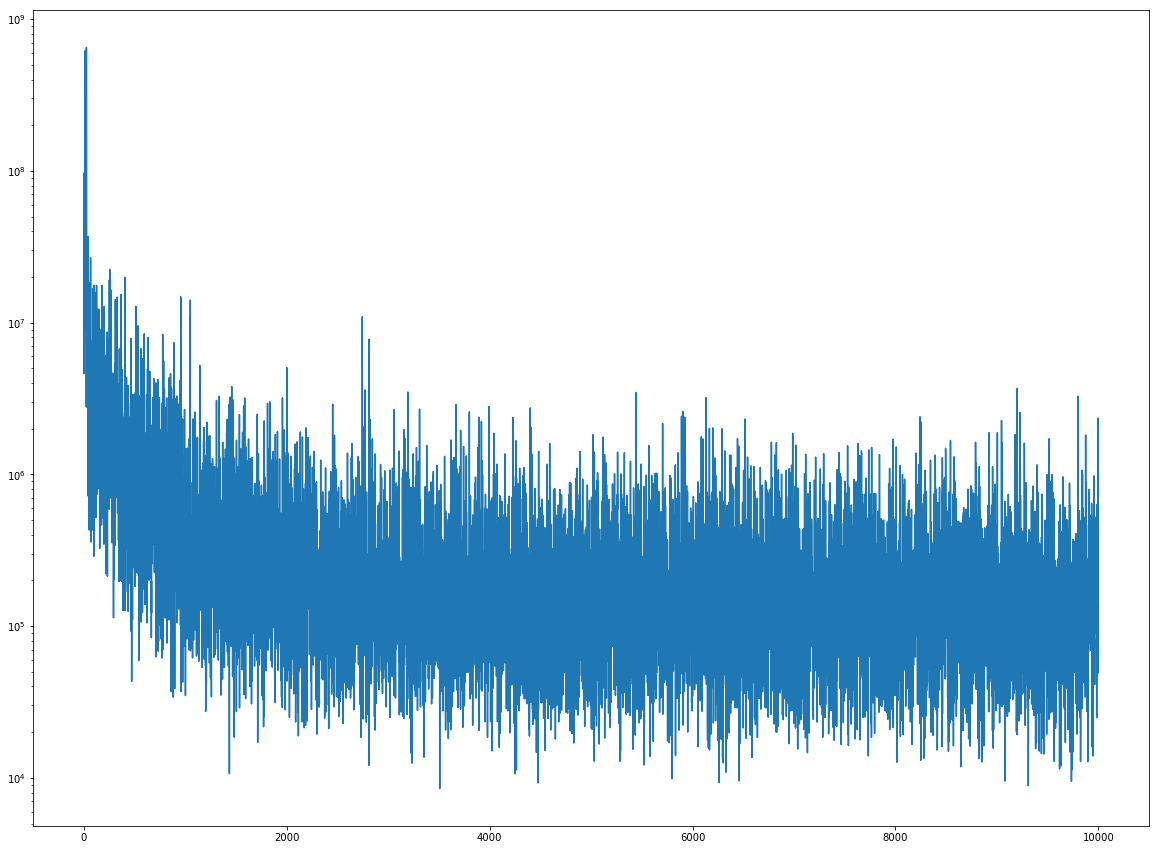

In [16]:
plt.semilogy(learning_curve)

In [17]:
#for variable in variables_evolutions:
#    if variable[0].ndim > 1 or variable[0].shape[0] > 1:
#        plt.figure()
#        for i in range(variable[0].ndim):
#            for j in range(variable[0].shape[i]):
#                plt.plot(variable[i][j])
#    else:
#        plt.figure()
#        plt.plot(variable)

In [18]:
x_hat = ed.copy(x, {z: qz, mu: qmu, sigma2_mu_k:qsigma2_mu_k, sigma2_mu_d:qsigma2_mu_d, sigma2_obs_n:qsigma2_obs_n, sigma2_obs_d:qsigma2_obs_d})

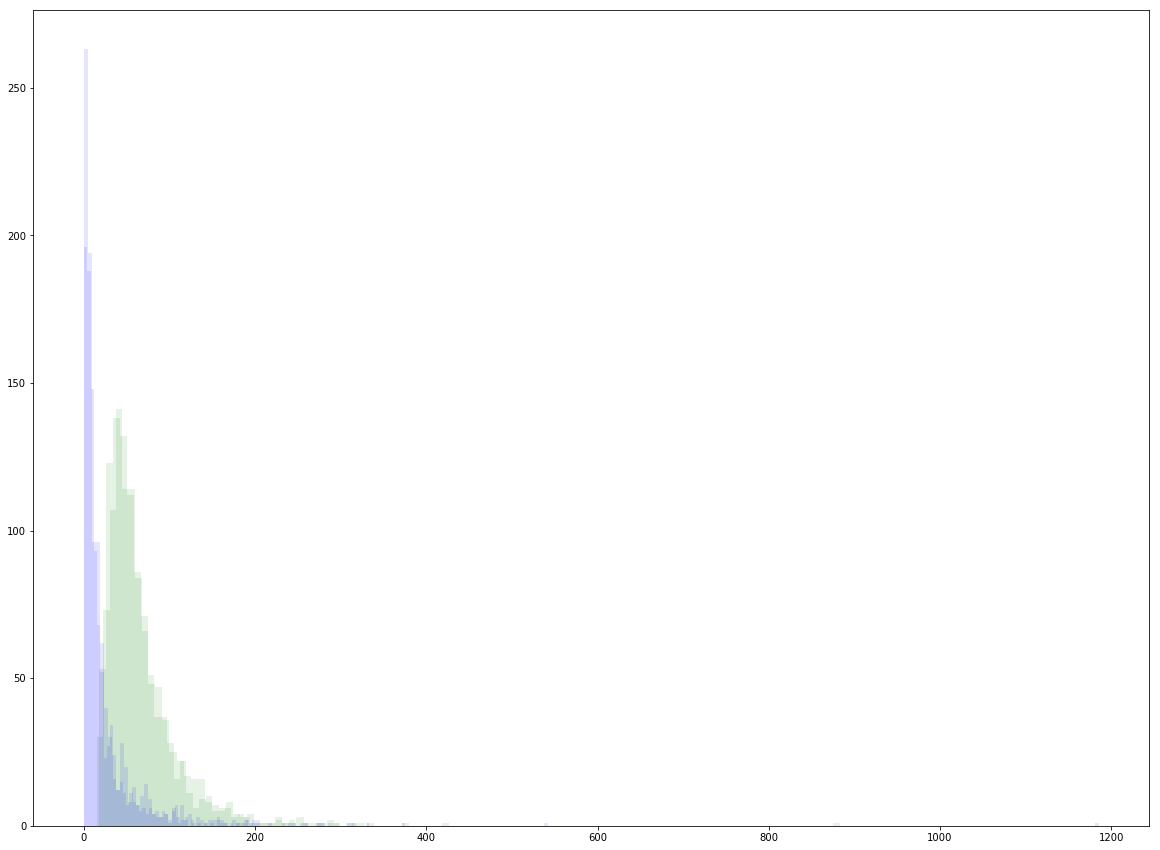

In [19]:
T = 1000
[plt.hist(var,'auto', color='g',alpha=.1) for var in sigma2_mu_d.sample(T).eval().T];
[plt.hist(var,'auto', color='b',alpha=.1) for var in qsigma2_mu_d.sample(T).eval().T];

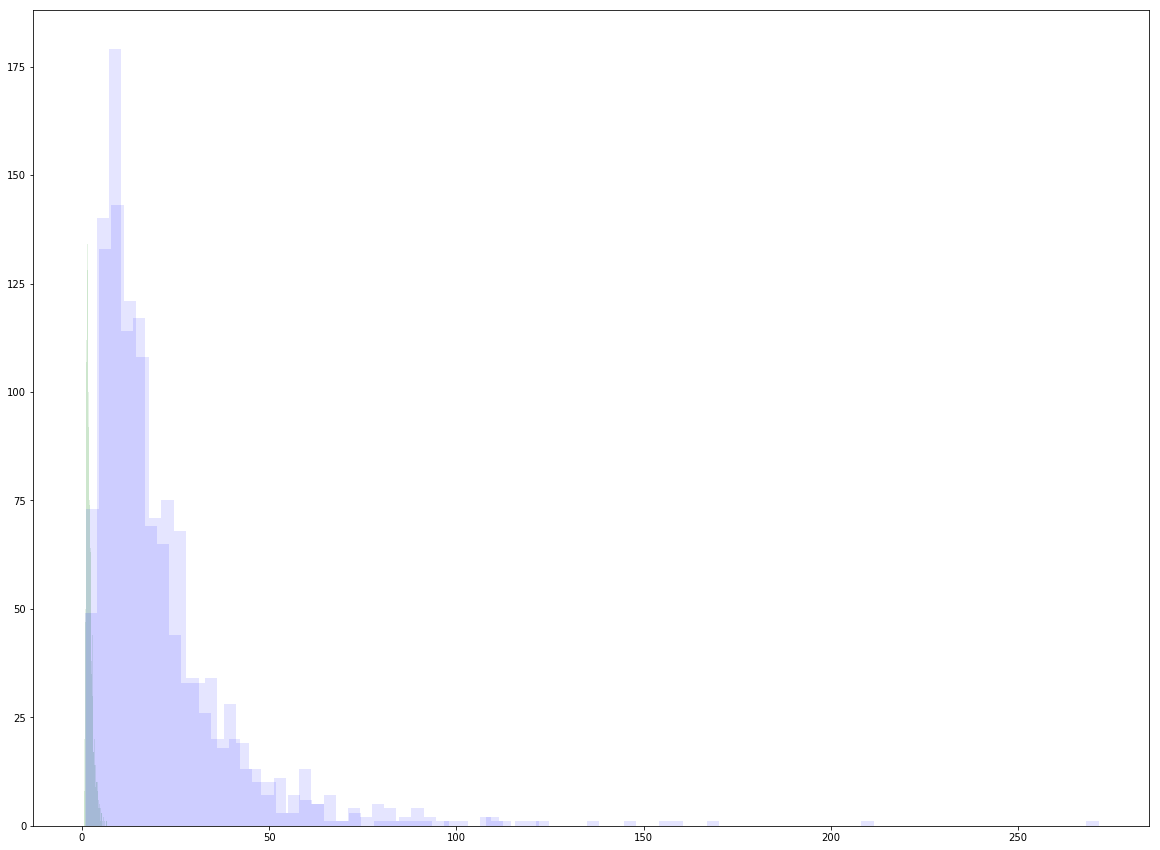

In [20]:
[plt.hist(var,'auto', color='g',alpha=.1) for var in sigma2_obs_d.sample(T).eval().T];
[plt.hist(var,'auto', color='b',alpha=.1) for var in qsigma2_obs_d.sample(T).eval().T];

In [21]:
x_hat_point = ed.copy(x, {mu: qmu.mode(), sigma2_mu_k:qsigma2_mu_k, sigma2_mu_d:qsigma2_mu_d, sigma2_obs_n:qsigma2_obs_n, sigma2_obs_d:qsigma2_obs_d})

In [22]:
qmu_mean.eval()

array([[ 0.51505631, -0.65777153],
       [-0.52835059,  0.8824352 ]], dtype=float32)

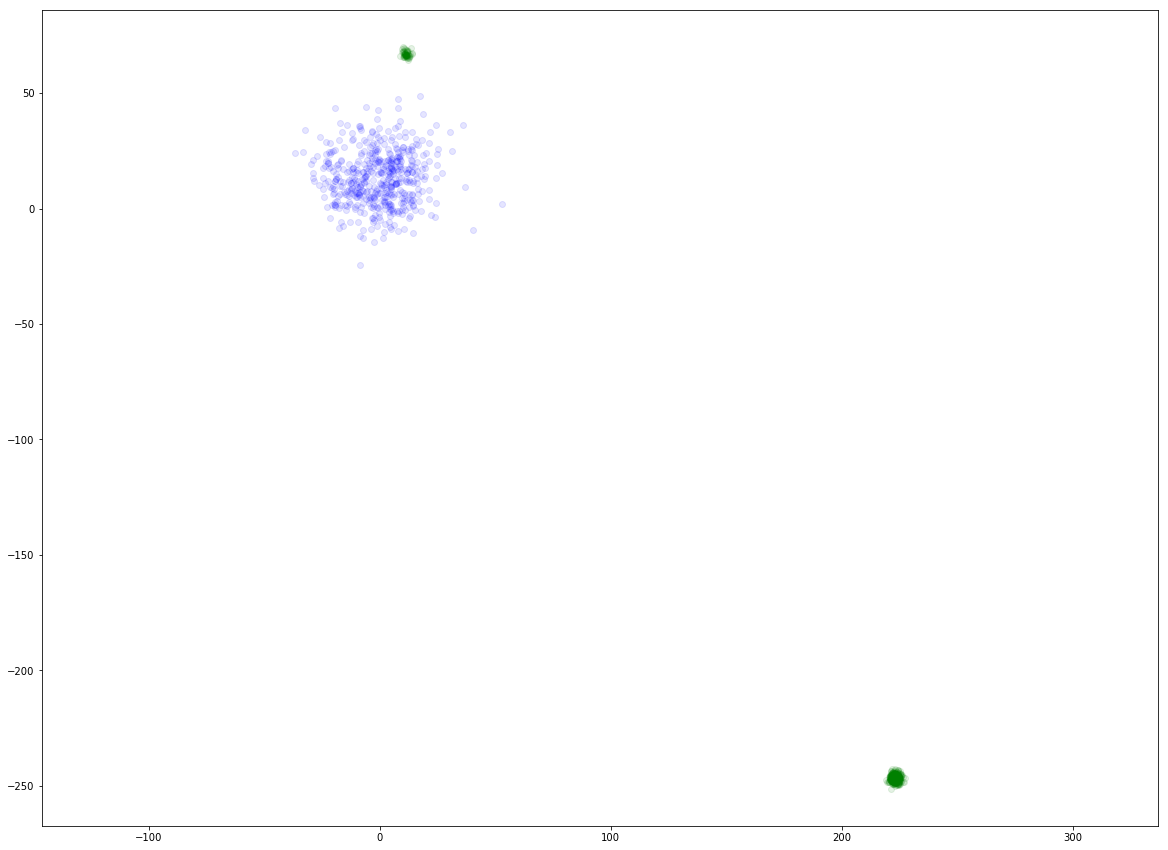

In [23]:
plt.scatter(*X_sample.T,color='g', alpha=.1)
#plt.scatter(*Gt.T,color='r')
plt.axis('equal');
X_hat_sample = x_hat.sample().eval()
plt.scatter(*X_hat_sample.T,color='b', alpha=.1)
plt.axis('equal');